In [62]:
import numpy as np 
import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule, NeuralRNN

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = MushroomBodyDataset()

print(f'Datum shape for input and output is (timesteps, neurons): {dataset[0]["dan"].shape}')
# dataset.data[0]

Datum shape for input and output is (timesteps, neurons): torch.Size([3, 15])


In [3]:
num_samples = len(dataset.data)
train_percentage, val_percentage = 0.6, 0.2
test_percentage = 1 - train_percentage - val_percentage

lengths = [
    int(train_percentage * num_samples), 
    int(val_percentage * num_samples),
    int(test_percentage * num_samples),
]

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))

print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 5400
Val dataset size: 1800
Test dataset size: 1800


# Hyperparams

In [13]:
hparams = {
    'batch_size': 8,
    'lr': 0.001,
    'max_epochs': 10,
    'min_epochs': 1
}

# Create Dataloaders

In [14]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Instantiate Model

In [22]:
model = NeuralRNNModule(
    input_dim=15,
    hidden_dim=15, 
    lr=hparams['lr']
)

In [23]:
batch = next(iter(train_dataloader))

In [24]:
# Check that the forward pass does what I expect
output = model(batch['dan'])
output.shape

torch.Size([8, 3, 15])

# Lets Try Train

In [25]:
logger = TensorBoardLogger("tb_logs", name="rnn", default_hp_metric=False)

In [26]:
logger.log_hyperparams(hparams)

In [64]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
    callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

# Visualise the trained weights

In [67]:
import matplotlib.pyplot as plt

lobes = ["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5']
greek_lobes = [r"$\alpha '_1$", r"$\alpha '_2$", r"$\alpha '_3$", 
              r"$\alpha _1$", r"$\alpha _2$", r"$\alpha_3$",
              r"$\beta '_1$", r"$\beta '_2$", r"$\beta _1$", r"$\beta _2$",
              r"$\gamma _1$", r"$\gamma _2$", r"$\gamma _3$", r"$\gamma _4$", r"$\gamma _5$", ]

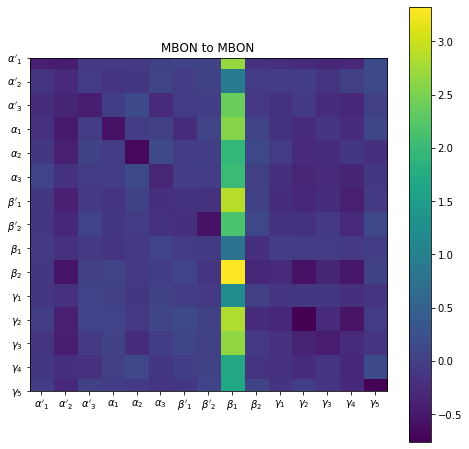

In [68]:
plt.figure(figsize=[8,8])
plt.imshow(model.rnn.W_hh.weight.detach().numpy())
plt.colorbar()
plt.xticks(range(0,15), greek_lobes)
plt.yticks(range(0,15), greek_lobes)
plt.title('MBON to MBON')
plt.show()

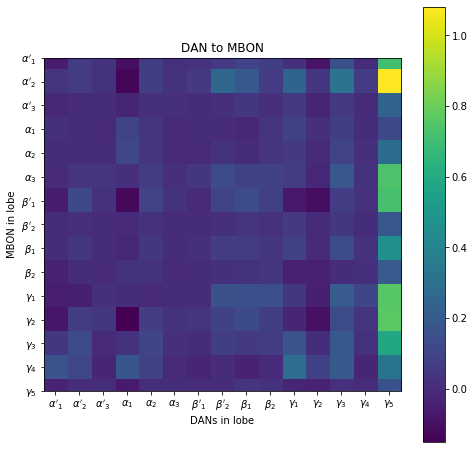

In [70]:
plt.figure(figsize=[8,8])
plt.imshow(model.rnn.W_xh.weight.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.xticks(range(0,15), greek_lobes)
plt.yticks(range(0,15), greek_lobes)

plt.title('DAN to MBON')
plt.xlabel('DANs in lobe')
plt.ylabel('MBON in lobe')
plt.show()